In [16]:
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (confusion_matrix,accuracy_score,classification_report)

In [2]:
def get_att_array(G,att_name):
    ret_array=np.zeros(nx.number_of_nodes(G))
    for i,n in enumerate(G.nodes()):
        ret_array[i]=G.nodes[n][att_name]
    return(ret_array)

Loading the Lazega Lawyer network and making the edges undirected:

In [3]:
lazega=nx.readwrite.graphml.read_graphml('lazega.gml')
lazega=lazega.to_undirected()

Constructing node features from the node attributes. We shall consider the "Office" attribute as the class label we want to predict:

In [4]:
attributes = ("Age","Seniority","Practice","Gender","Status")
classlabel ="Office"

att_features=np.zeros((nx.number_of_nodes(lazega),len(attributes))) 

for i,a in zip(range(len(attributes)),attributes):
    att_features[:,i]=get_att_array(lazega,a)

Y=  get_att_array(lazega,classlabel)  

for a in attributes:
    print("{} \t".format(a), end =" ")
print(classlabel)

for i in range(att_features.shape[0]):
    for j in range(att_features.shape[1]):
        print("{} \t".format(att_features[i,j]),end=" ")
    print(Y[i])    


Age 	 Seniority 	 Practice 	 Gender 	 Status 	 Office
64.0 	 31.0 	 1.0 	 1.0 	 1.0 	 1.0
62.0 	 32.0 	 2.0 	 1.0 	 1.0 	 1.0
59.0 	 31.0 	 2.0 	 1.0 	 1.0 	 1.0
53.0 	 28.0 	 1.0 	 1.0 	 1.0 	 1.0
50.0 	 23.0 	 2.0 	 1.0 	 1.0 	 1.0
46.0 	 20.0 	 2.0 	 1.0 	 1.0 	 1.0
49.0 	 9.0 	 1.0 	 1.0 	 1.0 	 1.0
41.0 	 15.0 	 1.0 	 1.0 	 1.0 	 1.0
67.0 	 13.0 	 1.0 	 1.0 	 1.0 	 2.0
53.0 	 25.0 	 2.0 	 1.0 	 1.0 	 1.0
50.0 	 23.0 	 1.0 	 1.0 	 1.0 	 1.0
52.0 	 24.0 	 2.0 	 1.0 	 1.0 	 1.0
56.0 	 1.0 	 2.0 	 1.0 	 1.0 	 2.0
46.0 	 19.0 	 2.0 	 1.0 	 1.0 	 1.0
43.0 	 17.0 	 1.0 	 1.0 	 1.0 	 1.0
45.0 	 16.0 	 1.0 	 1.0 	 1.0 	 1.0
47.0 	 13.0 	 1.0 	 2.0 	 1.0 	 1.0
38.0 	 10.0 	 2.0 	 2.0 	 1.0 	 1.0
59.0 	 31.0 	 1.0 	 1.0 	 1.0 	 2.0
63.0 	 29.0 	 2.0 	 1.0 	 1.0 	 2.0
45.0 	 18.0 	 1.0 	 1.0 	 1.0 	 2.0
43.0 	 15.0 	 2.0 	 1.0 	 1.0 	 2.0
44.0 	 15.0 	 1.0 	 1.0 	 1.0 	 1.0
53.0 	 25.0 	 2.0 	 1.0 	 1.0 	 1.0
57.0 	 22.0 	 1.0 	 1.0 	 1.0 	 1.0
36.0 	 8.0 	 2.0 	 2.0 	 1.0 	 1.0
53.0 	 7.0 	 

Constructing features from the singular value decomposition of the Adjacency and Laplacian matrices. Note that the feature construction here is jointly for all nodes, including the future training and testing nodes (transductive!). We only use the coefficients of the eigenvectors for the 10 smallest (adjacency matrix), respectively 10 largest (Laplacian) eigenvalues:


In [5]:
A=nx.linalg.graphmatrix.adjacency_matrix(lazega).todense()
svdA_features=np.linalg.svd(A)[0][:,0:10]
svdA_features=np.asarray(svdA_features)

L=nx.linalg.laplacianmatrix.laplacian_matrix(lazega).todense()
svdL_features=np.linalg.svd(L)[0][:,58:68]
svdL_features=np.asarray(svdL_features)

print(svdL_features)

[[ 4.70815770e-02  1.28607293e-01 -2.61123721e-02 -3.70457665e-02
  -8.44470905e-02  5.43439088e-02  8.54481436e-02 -3.69689334e-02
  -1.00002223e-02 -1.03947967e-02]
 [ 5.62584760e-02  6.35557261e-02  7.75272689e-02 -8.42872923e-02
  -9.22234410e-02  6.05965748e-02  8.83864770e-02 -3.49304139e-02
  -8.97038267e-03 -7.61149472e-03]
 [ 5.86962494e-02  6.16428596e-02 -2.59954492e-02 -1.89137054e-02
  -4.64065610e-02  1.85295711e-02  6.26195337e-02 -2.73221873e-02
  -2.79596348e-02 -1.07238125e-02]
 [ 3.39167246e-03  1.40965848e-01 -4.51817689e-02 -1.70625619e-02
  -8.02084982e-02  5.36721488e-02  7.58391611e-02 -3.21096816e-02
   3.13335575e-03 -1.21344771e-02]
 [ 2.51178923e-02  6.37165823e-02 -3.15991020e-02 -1.63566005e-02
  -5.44613795e-02  3.69343688e-02  6.15943048e-02 -2.59039920e-02
  -1.84176530e-02 -1.07982112e-02]
 [ 1.13156549e-01  3.16814741e-02 -3.13294525e-02 -2.14146348e-02
  -5.05561666e-02  3.38686857e-02  6.10232658e-02 -2.19221373e-02
  -3.32190271e-02  1.40510204e-02

A utility function that transforms an array of shape (\*,2) into a dictionary of node coordinates. The rows in the matrix A must conform to the order in which nodes are enumerated by G.nodes.  

In [6]:
def makecoords(G,A):
    coords={}
    for i,n in zip(range(nx.number_of_nodes(G)),G.nodes):
        coords[n]=A[i,:]
    return coords    

Lazega plotted using the 2 minimal Laplacian eignevectors:


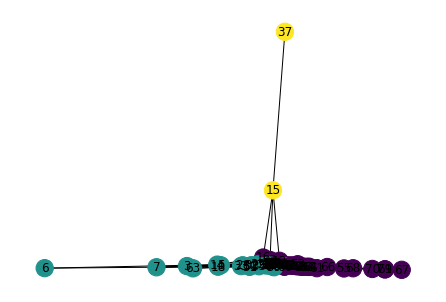

In [7]:
print("Lazega plotted using the 2 minimal Laplacian eignevectors:")
nx.draw(lazega,pos=makecoords(lazega,svdL_features[:,8:10]),with_labels=True,node_color=get_att_array(lazega,'Office'))

Lazega plotted using the 2 maximal Adjacency eignevectors:


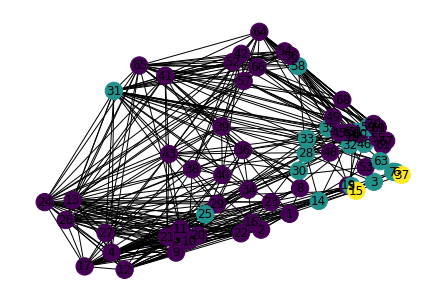

In [8]:
print("Lazega plotted using the 2 maximal Adjacency eignevectors:")
nx.draw(lazega,pos=makecoords(lazega,svdA_features[:,0:2]),with_labels=True,node_color=get_att_array(lazega,'Office'))

We now split the three feature sets and the class label vector into 80% training and 20% test nodes:

In [9]:
att_feat_train,att_feat_test,\
svdA_feat_train,svdA_feat_test,\
svdL_feat_train,svdL_feat_test,\
Y_train,Y_test\
=train_test_split(att_features,svdA_features,svdL_features,Y,train_size=0.8)

For the following, select one of the 3 feature sets:

In [10]:
feat_train=att_feat_train
feat_test=att_feat_test

In [11]:
feat_train=svdA_feat_train
feat_test=svdA_feat_test

In [12]:
feat_train=svdL_feat_train
feat_test=svdL_feat_test

Learn a decision tree classifier:

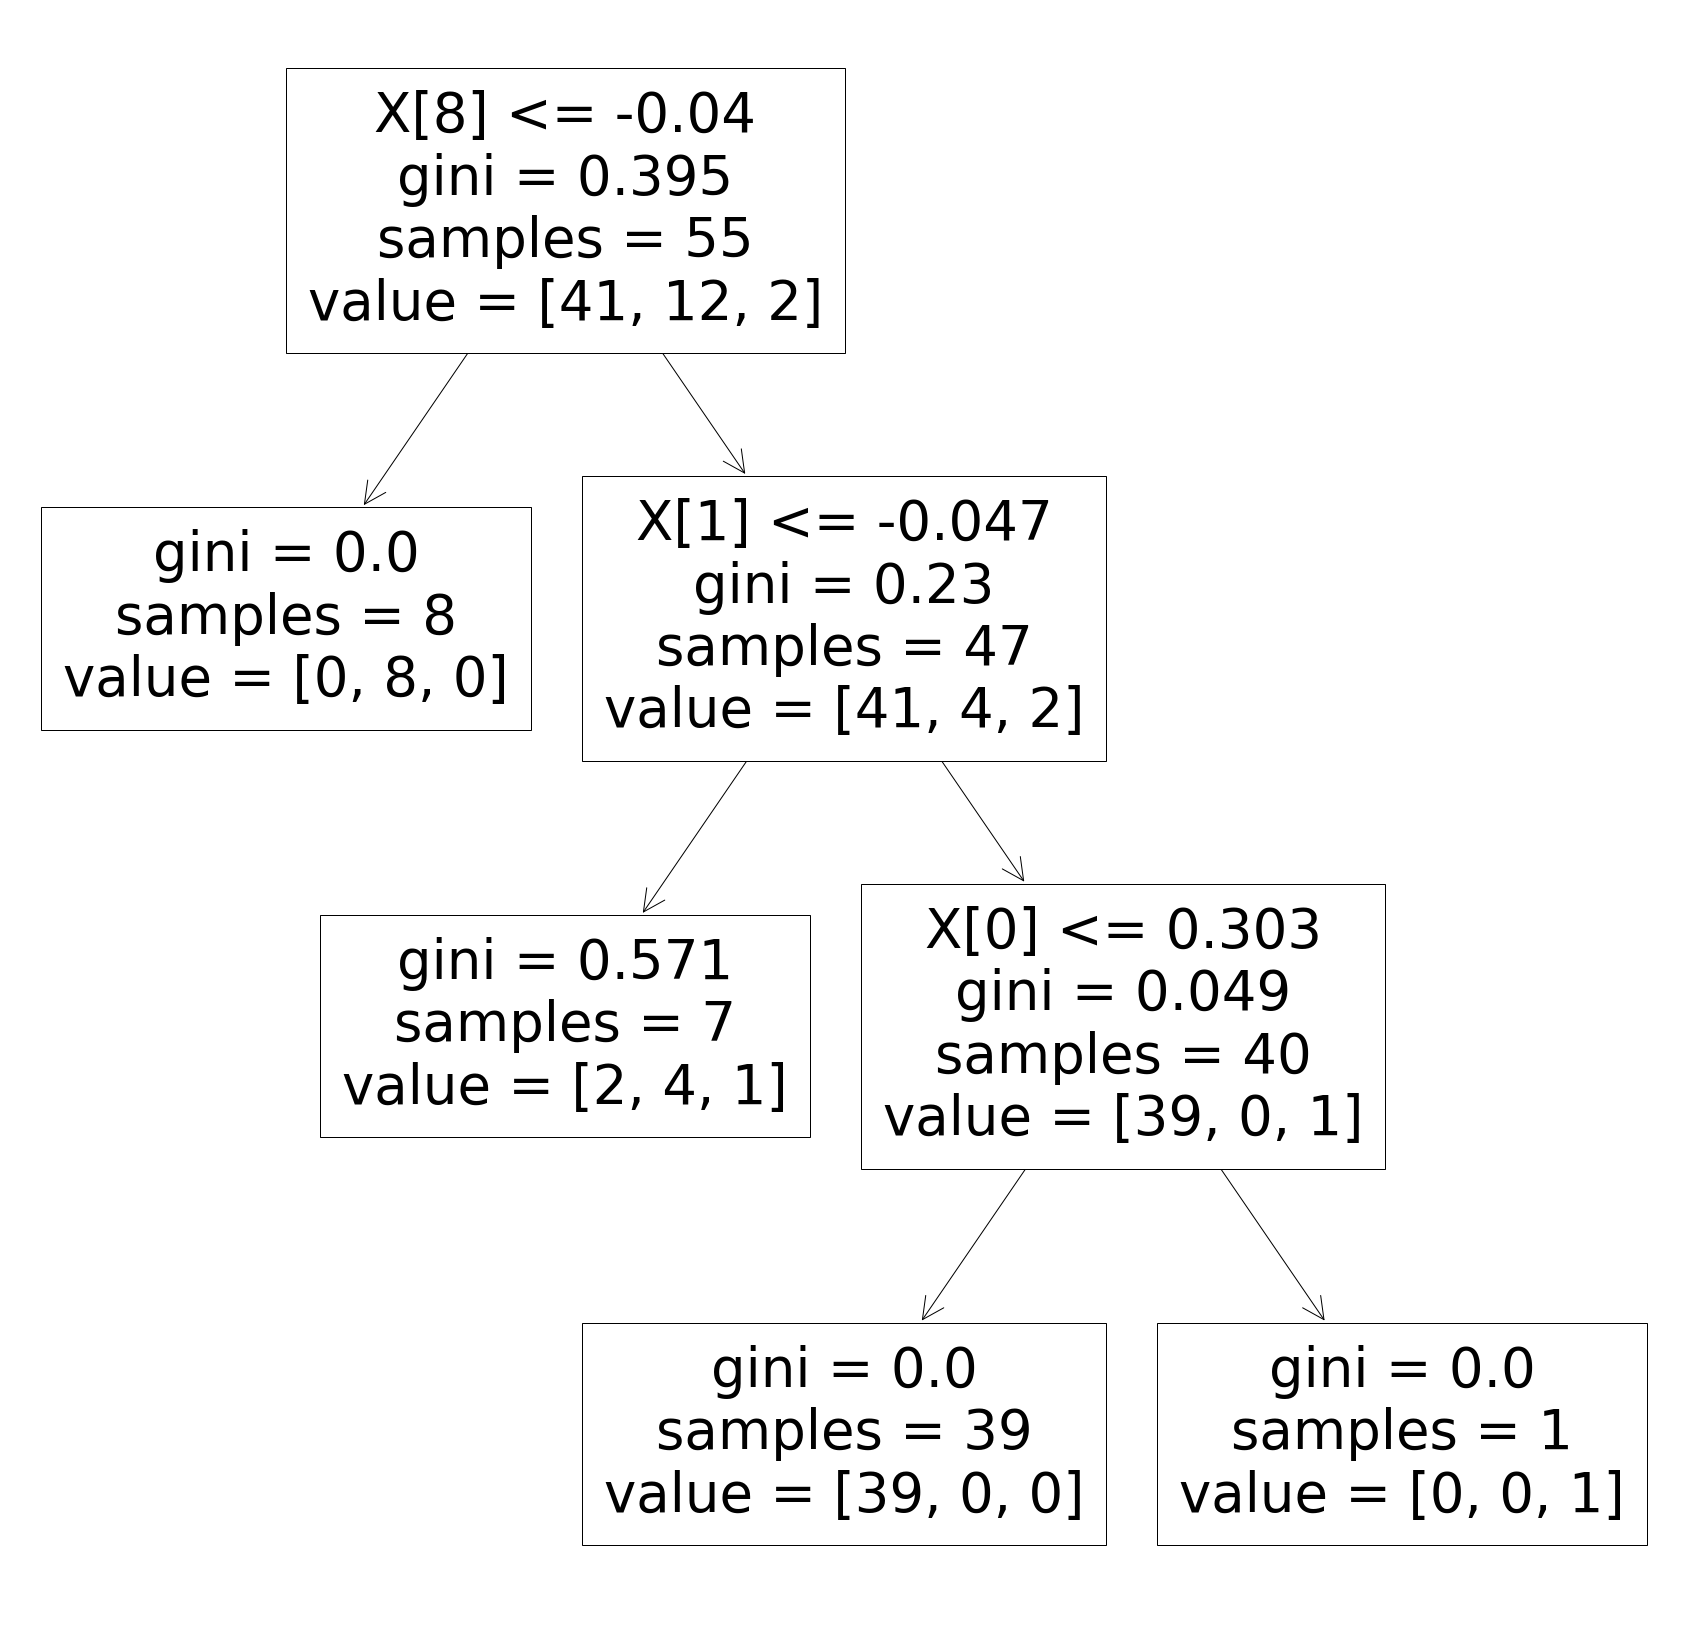

Accuracy on training data: 0.9454545454545454


In [13]:
dtree=DecisionTreeClassifier(min_samples_split=8,max_depth=4)

dtree.fit(feat_train,Y_train)

plt.figure(figsize=(30,30))
plot_tree(dtree)
plt.show()

print("Accuracy on training data: {}".format(dtree.score(feat_train,Y_train)))

Evaluate the learned decision tree on the test nodes:

In [14]:
#predict
Y_pred = dtree.predict(feat_test)

#evaluate
print("Confusion matrix: \n{}".format(confusion_matrix(Y_test,Y_pred)))
print("Accuracy: {}".format(accuracy_score(Y_test,Y_pred)))

Confusion matrix: 
[[5 2]
 [0 7]]
Accuracy: 0.8571428571428571


Now the same with a logistic regression classifier:

In [15]:
#learn:
lr=LogisticRegression(solver="lbfgs",class_weight="balanced")
lr.fit(feat_train,Y_train)

#test:
Y_pred=lr.predict(feat_test)

#evaluate:
print("Test data confusion matrix: \n {}".format(confusion_matrix(Y_test,Y_pred)))
print("Accuracy: {}".format(accuracy_score(Y_test,Y_pred)))

Test data confusion matrix: 
 [[5 2]
 [2 5]]
Accuracy: 0.7142857142857143
